In [2]:
%matplotlib inline
import os
import glob
import pandas as pd
import fiona
import rasterio
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
year = 2015

The first input is a list of GeoTIFF files in our directory, sorted alphabetically (ie, by date in ascending order).

In [4]:
snowcover_dir = "/Volumes/CWMobileSSD/Geodata_fires/2020_COVID_AFS/natice_noaa/"
geotiff_subdir = 'GeoTIFF_Products/'
geotiff_dir = os.path.join(snowcover_dir, geotiff_subdir)
tiffiles = sorted(glob.glob(os.path.join(geotiff_dir, f"*{year}*.tif")))

The second input is a dictionary of (multi)polygons for each Predictive Service Area (PSA). They are, like the GeoTIFFs, in Alaska Albers Equal Area projection. 

In [5]:
psa_file = "/Volumes/CWMobileSSD/Geodata_fires/AICC/AK_PSA_boundaries/predictive_service_areas.shp"
psa_shapes = {}
with fiona.open(psa_file, "r") as shapefile:
    for feature in shapefile:
        psa_shapes[feature['properties']['PSA_NAME']] = feature["geometry"]

In [6]:
psa_shapes.keys()

dict_keys(['Kuskokwim Valley', 'Northern Panhandle', 'Central Panhandle', 'Southern Panhandle', 'Matanuska Valley and Anchorage', 'Kenai Peninsula', 'Tanana Valley-West', 'Susitna Valley', 'Tanana Zone-South', 'Koyukuk and Upper Kobuk', 'Lower Yukon', 'Middle Yukon', 'Upper Yukon Valley', 'Copper River Basin', 'Kodiak Island', 'North Slope', 'Tanana Zone-North', 'Seward Peninsula', 'Bristol Bay and AK Peninsula', 'Yukon-Kuskokwim Delta', 'Tanana Valley-East'])

### Try it out for one sample GeoTiff, and two selected PSA.

Let's pick a GeoTIFF. We can extract the date from the filename, which is unelegant, but effective.

In [7]:
sampletiff = tiffiles[10]
sampletiff[90:98]

'20150311'

We open it using `rasterio`. It expects a list of shapes, but we only provide a list of one. `out_image` will be an array containing a single image. 

In [8]:
with rasterio.open(sampletiff) as src:
    out_image, out_transform = rasterio.mask.mask(src, [psa_shapes['Tanana Valley-West']], crop=True)
    out_meta = src.meta

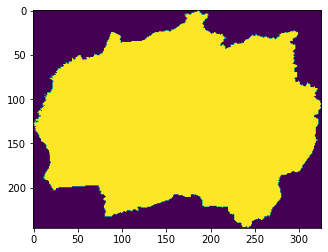

In [9]:
plt.imshow(out_image[0])   

We need to count the unique values in the masked raster. The values are 0 - no data (outside mask), 1 - water, 2 - snow-free ground, 3 - ice, 4 - snow. Note that if there are no pixels for a given value, the value will not appear in the output. We therefore need to populate a short array, including the values with zero counts.

In [10]:
unique_elements, counts_elements = np.unique(out_image[0], return_counts=True)
unique_elements, counts_elements

(array([0, 3], dtype=uint8), array([26879, 53317]))

In [11]:
counts = np.zeros(5)
counts[unique_elements] = counts_elements
counts

array([26879.,     0.,     0., 53317.,     0.])

The Tanana Valley-West zone is still entirely frozen on that date. The counts for snow-free ground and water are zero.

In [12]:
sum(counts[3:]) / sum(counts[1:])

1.0

Let's do the exact same thing with the Kenai Peninsula.

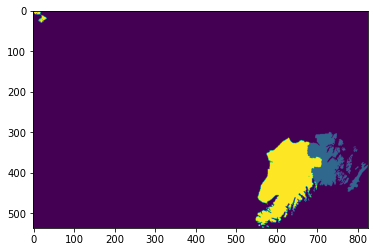

In [13]:
with rasterio.open(sampletiff) as src:
    out_image, out_transform = rasterio.mask.mask(src, [psa_shapes['Kenai Peninsula']], crop=True)
    out_meta = src.meta
plt.imshow(out_image[0])  

In [14]:
unique_elements, counts_elements = np.unique(out_image[0], return_counts=True)
counts = np.zeros(5)
counts[unique_elements] = counts_elements
sum(counts[3:]) / sum(counts[1:])

0.6927038317487756

### A quick-and-dirty time series for sample PSAs

As a sanity check / quality control, let's produce sample time series plots for these two PSAs. They look quite reasonable. 

In [15]:
labels = []
tanana_west = []
kenai = []
for tiffile in tiffiles:
    labels.append(tiffile[90:98])
    with rasterio.open(tiffile) as src:
        kenai_img, _ = rasterio.mask.mask(src, [psa_shapes['Kenai Peninsula']], crop=True)
        tanana_west_img, _ = rasterio.mask.mask(src, [psa_shapes['Tanana Valley-West']], crop=True)
    unique_kenai, counts_kenai = np.unique(kenai_img[0], return_counts=True)
    counts = np.zeros(5)
    counts[unique_kenai] = counts_kenai
    kenai.append(sum(counts[3:]) / sum(counts[1:]))
    unique_tanana_west, counts_tanana_west = np.unique(tanana_west_img[0], return_counts=True)
    counts = np.zeros(5)
    counts[unique_tanana_west] = counts_tanana_west
    tanana_west.append(sum(counts[3:]) / sum(counts[1:]))

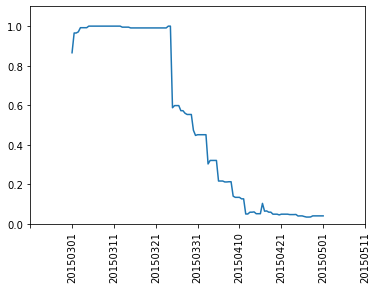

In [16]:
plt.plot(tanana_west)
locs, _ = plt.xticks()
_ = plt.xticks(locs, [''] + labels[::10], rotation=90)
_ = plt.ylim((0,1.1))

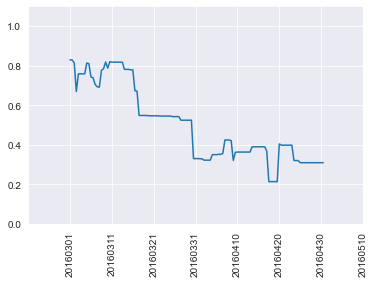

In [224]:
plt.plot(kenai)
locs, _ = plt.xticks()
_ = plt.xticks(locs, [''] + labels[::10], rotation=90)
_ = plt.ylim((0,1.1))

### Let's generate, save and visualize a complete dataset

We will first put the data in a large dictionary, then generate a Pandas Dataframe from the dictionary. 

In [17]:
datadict = {}

for tiffile in tiffiles:
    try: 
        datadict['date'].append(tiffile[90:98])
    except KeyError:
        datadict['date'] = [tiffile[90:98]]
    with rasterio.open(tiffile) as src:
        for psa in psa_shapes:
            psa_img, _ = rasterio.mask.mask(src, [psa_shapes[psa]], crop=True)
            unique_psa, counts_psa = np.unique(psa_img[0], return_counts=True)
            counts = np.zeros(5)
            counts[unique_psa] = counts_psa
            try: 
                datadict[psa].append(sum(counts[3:]) / sum(counts[1:]))
            except KeyError:
                datadict[psa] = [sum(counts[3:]) / sum(counts[1:])]   

In [18]:
snowdata_df = pd.DataFrame.from_dict(datadict)
snowdata_df

,date,Kuskokwim Valley,Northern Panhandle,Central Panhandle,Southern Panhandle,Matanuska Valley and Anchorage,Kenai Peninsula,Tanana Valley-West,Susitna Valley,Tanana Zone-South,...,Middle Yukon,Upper Yukon Valley,Copper River Basin,Kodiak Island,North Slope,Tanana Zone-North,Seward Peninsula,Bristol Bay and AK Peninsula,Yukon-Kuskokwim Delta,Tanana Valley-East
0,20150301,1.000000,0.000000,0.000000,0.000000,0.234492,0.632203,0.865315,0.882404,1.000000,...,0.99991,0.999968,0.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,0.308515
1,20150302,1.000000,0.000000,0.000000,0.000000,0.249167,0.632203,0.965264,0.992861,1.000000,...,0.99991,0.999968,0.025196,1.000000,1.000000,1.000000,1.0,1.000000,1.0,0.348212
2,20150303,1.000000,0.000000,0.000000,0.000000,0.249167,0.632203,0.965264,0.992861,1.000000,...,0.99991,0.999968,0.025196,1.000000,1.000000,1.000000,1.0,1.000000,1.0,0.350532
3,20150304,1.000000,0.000000,0.000000,0.000000,0.255910,0.632203,0.971060,0.993704,1.000000,...,0.99991,0.980851,0.045927,1.000000,1.000000,1.000000,1.0,1.000000,1.0,0.281076
4,20150305,1.000000,0.000000,0.000000,0.000000,0.255910,0.632203,0.992066,0.993704,1.000000,...,0.99991,0.999968,0.057305,1.000000,1.000000,1.000000,1.0,1.000000,1.0,0.597783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,20150626,0.033427,0.434760,0.155681,0.071142,0.128510,0.222990,0.040062,0.131070,0.027679,...,0.00000,0.000013,0.238097,0.053682,0.017971,0.000397,0.0,0.063707,0.0,0.021927
117,20150627,0.026006,0.434760,0.155681,0.071142,0.128510,0.222990,0.040062,0.127559,0.027679,...,0.00000,0.000013,0.238097,0.053682,0.017971,0.000397,0.0,0.055269,0.0,0.021927
118,20150628,0.026006,0.427818,0.155681,0.071142,0.128510,0.222990,0.040062,0.127559,0.027679,...,0.00000,0.000013,0.235108,0.053682,0.017971,0.000397,0.0,0.055269,0.0,0.018012
119,20150629,0.026006,0.360536,0.155681,0.071142,0.128510,0.222990,0.040062,0.127559,0.027679,...,0.00000,0.000013,0.233255,0.053682,0.016202,0.000397,0.0,0.055269,0.0,0.018012


In [19]:
snowdata_df.index = pd.to_datetime(snowdata_df["date"], format="%Y%m%d")
snowdata_df[snowdata_df.index.month==4]

,date,Kuskokwim Valley,Northern Panhandle,Central Panhandle,Southern Panhandle,Matanuska Valley and Anchorage,Kenai Peninsula,Tanana Valley-West,Susitna Valley,Tanana Zone-South,...,Middle Yukon,Upper Yukon Valley,Copper River Basin,Kodiak Island,North Slope,Tanana Zone-North,Seward Peninsula,Bristol Bay and AK Peninsula,Yukon-Kuskokwim Delta,Tanana Valley-East
date,,,,,,,,,,,,,,,,,,,,,
2015-04-01,20150401,0.807724,0.712224,0.451131,0.377491,0.758290,0.540406,0.990885,0.954793,0.996351,...,1.000000,1.000000,0.933673,0.390182,1.000000,1.000000,1.000000,0.393518,0.809987,1.000000
2015-04-02,20150402,0.807724,0.712224,0.451131,0.377491,0.758290,0.540406,0.990885,0.954793,0.996351,...,1.000000,1.000000,0.933673,0.390182,1.000000,1.000000,1.000000,0.393518,0.809987,1.000000
2015-04-03,20150403,0.807724,0.712224,0.451131,0.377491,0.758290,0.540406,0.990885,0.954793,0.996351,...,1.000000,1.000000,0.933673,0.390182,1.000000,1.000000,1.000000,0.393518,0.810328,1.000000
2015-04-04,20150404,0.785428,0.712224,0.451131,0.377491,0.740044,0.540370,0.990885,0.923413,0.996351,...,1.000000,1.000000,0.933673,0.134283,1.000000,1.000000,1.000000,0.383510,0.809315,1.000000
2015-04-05,20150405,0.812480,0.712224,0.451131,0.377491,0.740044,0.540370,0.990885,0.923413,0.996351,...,1.000000,1.000000,0.933673,0.134283,1.000000,1.000000,1.000000,0.449113,0.997457,1.000000
2015-04-06,20150406,0.812480,0.712224,0.451131,0.377491,0.740044,0.540370,0.990885,0.923413,0.996351,...,1.000000,1.000000,0.933673,0.134283,1.000000,1.000000,1.000000,0.449113,0.997457,1.000000
2015-04-07,20150407,0.812480,0.712224,0.451131,0.377491,0.740044,0.540370,0.990885,0.923413,0.996351,...,1.000000,1.000000,0.933673,0.134283,1.000000,1.000000,1.000000,0.449113,0.997457,1.000000
2015-04-08,20150408,0.887902,0.712224,0.451131,0.377491,0.740044,0.540370,0.990885,0.923590,0.996351,...,1.000000,1.000000,0.933673,0.134283,1.000000,1.000000,1.000000,0.695921,0.997457,1.000000
2015-04-09,20150409,0.887902,0.712224,0.451131,0.377491,0.740044,0.540370,0.990885,0.923590,0.996351,...,1.000000,1.000000,0.933673,0.134283,1.000000,1.000000,1.000000,0.695921,0.997457,1.000000


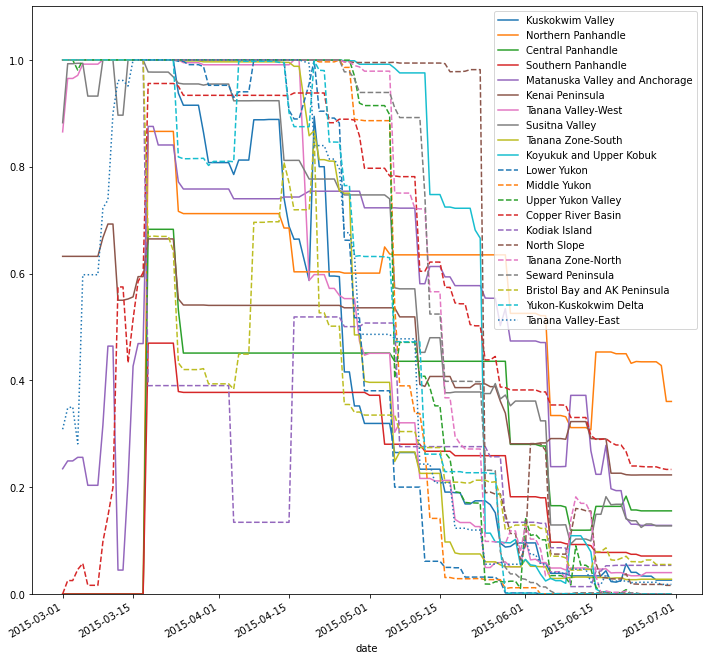

In [20]:
_ = snowdata_df.plot(figsize=(12,12), ylim=(0,1.1), style=['-']*10+['--']*10+[':'])

In [21]:
PSA0 = [
    'North Slope',
    'Koyukuk and Upper Kobuk',
    'Seward Peninsula',
    'Tanana Zone-North',
]
PSA1 = [
    'Lower Yukon',
    'Middle Yukon',
    'Kuskokwim Valley',
    'Yukon-Kuskokwim Delta',
]
PSA2 = [
    'Tanana Valley-West',
    'Tanana Zone-South',
    'Tanana Valley-East',
    'Upper Yukon Valley',
]
PSA3 = [
    'Susitna Valley',
    'Matanuska Valley and Anchorage',
    'Copper River Basin',
]
PSA4 = [
    'Bristol Bay and AK Peninsula',
    'Kenai Peninsula',
    'Kodiak Island',
]
PSA5 = [
    'Northern Panhandle', 
    'Central Panhandle', 
    'Southern Panhandle'
]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x124ad76d8>,
      dtype=object)

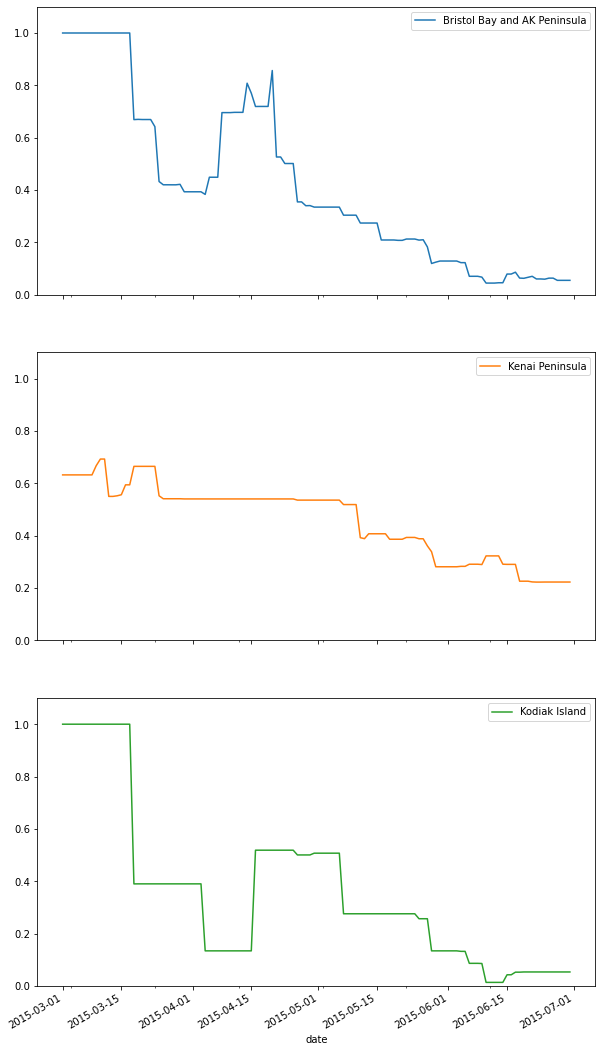

In [22]:
snowdata_df[PSA4].plot(subplots=True, figsize=(10,20), ylim=(0,1.1))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1259cc978>,
      dtype=object)

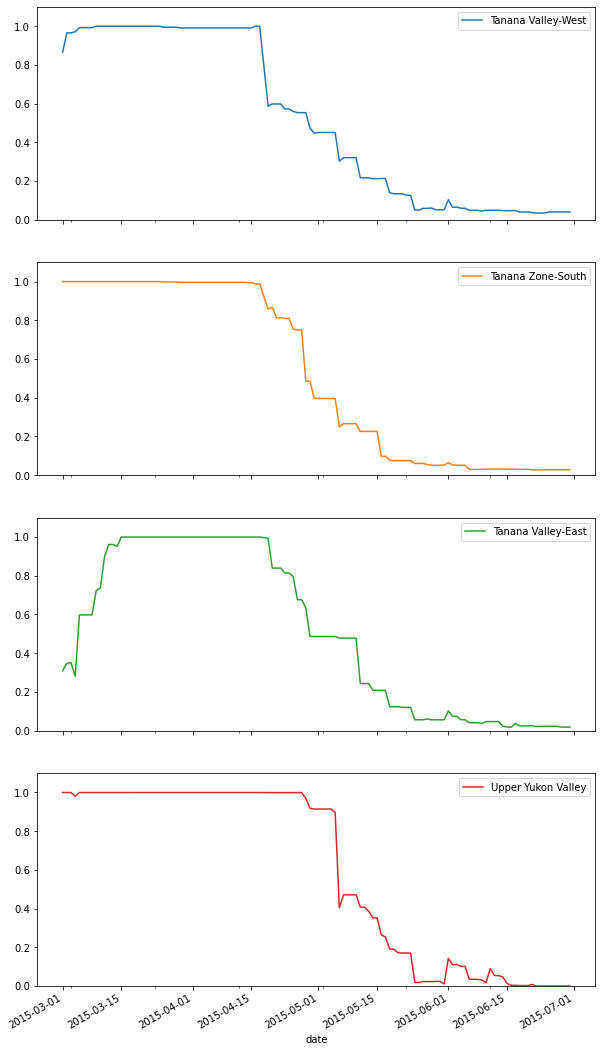

In [23]:
snowdata_df[PSA2].plot(subplots=True, figsize=(10,20), ylim=(0,1.1))

In [24]:
sns.set_style('darkgrid')

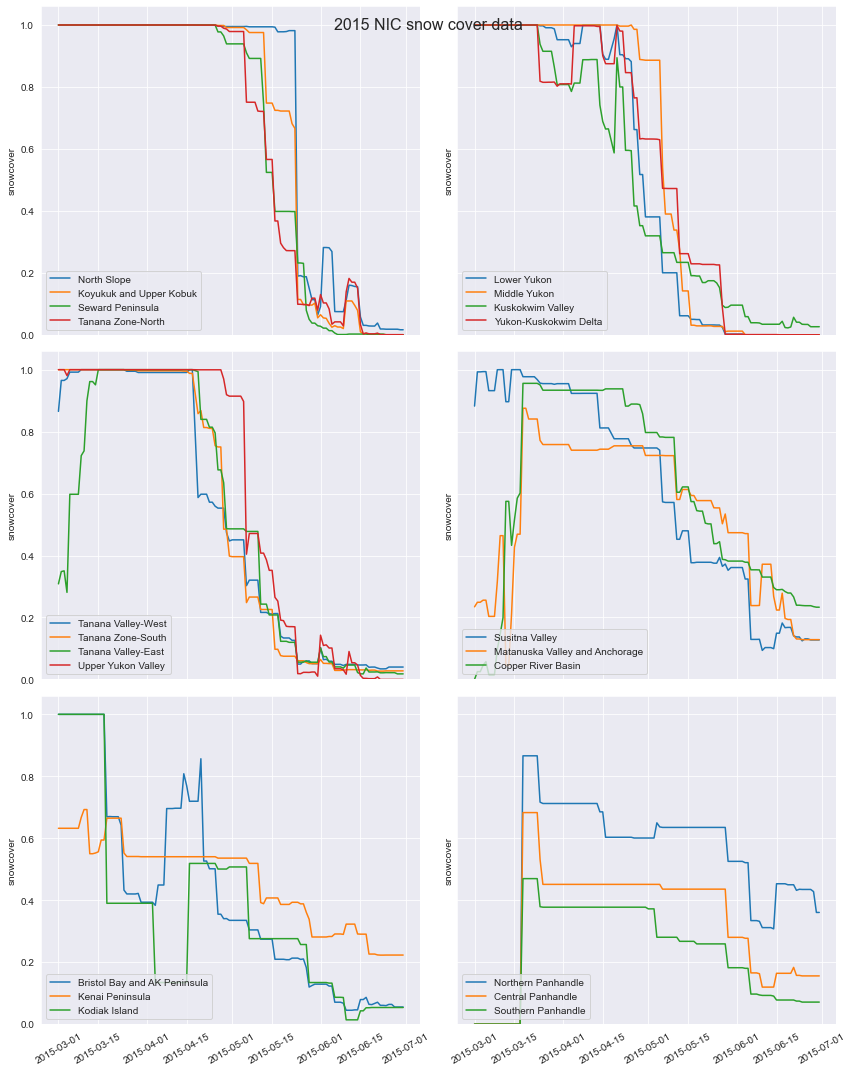

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15), sharex=True, sharey=True)
for ax, grp in zip(axes.flatten(), [PSA0, PSA1, PSA2, PSA3, PSA4, PSA5,]):
    g = sns.lineplot(data = snowdata_df[grp], dashes=False, ax=ax)
    g.set_xlabel("")
    g.set_ylabel("snowcover")
    g.set_ylim((0,1.06))
    _ = plt.setp(g.get_xticklabels(), rotation=30)
    _ = ax.legend(loc='lower left')
_ = fig.suptitle(f"{year} NIC snow cover data", fontsize=16)
plt.tight_layout()

### Saving data to file

In [26]:
compression_opts = dict(method='zip', archive_name=f'snowcoverAK_{year}.csv')
snowdata_df.to_csv(f'snowcoverAK_{year}.zip', compression=compression_opts)